### Twitter Sentiment Analyis

Connect to Google Drive

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Data

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Data


Install packages

In [ ]:
!pip install vaderSentiment
!pip install transformers
!pip install -Uqq ipdb
!pip install langdetect
import ipdb
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=4af6b4c31d5f92ca8a9d5c62c84f0f073b007fc0403ef95ac96476e151604fea
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


### Data Cleaning

Loading datasets

In [ ]:
# Load the datasets
election_2016_data = pd.read_csv('2016_donaldtrump_clean.csv', lineterminator='\n')
election_2020_data = pd.read_csv('2020_donaldtrump_clean.csv', lineterminator='\n')

Lanaguage detection for 2020 dataset

In [ ]:
from tqdm.notebook import tqdm  # import tqdm library
import pandas as pd
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Remove rows with empty or whitespace-only values in the "Cleaned_Text" column
election_2020_data = election_2020_data[election_2020_data['Cleaned_Text'].str.strip().astype(bool)]

# Detect the language of each tweet and store it in a new column called "Language"
def detect_lang(text):
    try:
        return detect(text)
    except LangDetectException:
        return ''

election_2020_data['Language'] = election_2020_data['Cleaned_Text'].apply(lambda x: detect_lang(x) if isinstance(x, str) else '')

Natural Language Toolkit (NLTK)

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.lower()
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    text = re.sub(r'\W', ' ', text)

    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]

    return ' '.join(tokens)

election_2016_data['Cleaned_Text'] = election_2016_data['tweet_text'].apply(clean_text)
election_2020_data['Cleaned_Text'] = election_2020_data['tweet_text'].apply(clean_text)

Applying Ground Truth Sentiment Labels using VADER

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Function to calculate the sentiment using VADER
def sentiment_vader(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)

    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    # Define sentiment categories
    if compound >= 0.75:
        overall_sentiment = "Strongly Positive"
    if compound >= 0.4:
        overall_sentiment = "Positive"
    elif compound >= 0.1:
        overall_sentiment = "Slightly Positive"
    elif compound <= -0.75:
        overall_sentiment = "Strongly Negative"
    elif compound <= -0.4:
        overall_sentiment = "Negative"
    elif compound <= -0.1:
        overall_sentiment = "Slightly Negative"
    else:
        overall_sentiment = "Neutral"

    return negative, neutral, positive, compound, overall_sentiment


#Test samples
election_2016_data = election_2016_data.sample(n=750, random_state=44)
election_2020_data = election_2020_data.sample(n=750, random_state=44)

#Fill na values
# Replace NaN values with an empty string
election_2016_data['Cleaned_Text'].fillna('', inplace=True)
election_2020_data['Cleaned_Text'].fillna('', inplace=True)

# Extract relevant information and calculate sentiment
election_2016_data['negative'], election_2016_data['neutral'], election_2016_data['positive'], election_2016_data['compound'], election_2016_data['sentiment'] = zip(*election_2016_data['Cleaned_Text'].dropna().apply(sentiment_vader))
election_2020_data['negative'], election_2020_data['neutral'], election_2020_data['positive'], election_2020_data['compound'], election_2020_data['sentiment'] = zip(*election_2020_data['Cleaned_Text'].dropna().apply(sentiment_vader))


### Neural Network Models, Training, and Prediction


MLP Classifier Model

In [ ]:
# Prepare the data for training and testing
X = election_2016_data[['negative', 'positive', 'neutral', 'compound']]
y = election_2016_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=1)
clf.fit(X_train, y_train)

# Predict sentiment for the 2020 dataset
y_2020_pred = clf.predict(election_2020_data[['negative', 'positive', 'neutral', 'compound']])
election_2020_data['predicted_sentiment'] = y_2020_pred

# Evaluate the model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save the 2020 dataset with predictions
election_2016_data.to_csv('750_random_Sample_2016_election_data_with_predictions.csv', index=False)
election_2020_data.to_csv('750_random_Sample_2020_election_data_with_predictions.csv', index=False)

# Print results
print("\nSample of 2020 election data with predicted sentiment:")
print(election_2020_data[['Cleaned_Text', 'predicted_sentiment']])


Accuracy: 0.9866666666666667
                   precision    recall  f1-score   support

         Negative       1.00      1.00      1.00        18
          Neutral       0.98      0.98      0.98        52
         Positive       1.00      1.00      1.00        32
Slightly Negative       0.95      1.00      0.98        21
Slightly Positive       1.00      0.94      0.97        18
Strongly Negative       1.00      1.00      1.00         9

         accuracy                           0.99       150
        macro avg       0.99      0.99      0.99       150
     weighted avg       0.99      0.99      0.99       150


Sample of 2020 election data with predicted sentiment:
                                             Cleaned_Text predicted_sentiment
166604  terrified little boy trump going burn face los...   Strongly Negative
114476  lol clicked trump top 5 story negative trump s...            Negative
303607  tomorrow important day usa taco tuesday win so...            Positive
275619  pr

RobertaForSequenceClassification Model

Index(['index', 'id', 'candidate_id', 'tweet_id', 'polarity', 'subjectivity',
       'retweet_count', 'favorite_count', 'device', 'retweeted_status_id',
       'lang', 'state', 'tweet_text', 'created_at', 'inserted_at',
       'updated_at', 'tw_user_id', 'latitude', 'longitude\r', 'Cleaned_Text',
       'negative', 'neutral', 'positive', 'compound', 'sentiment'],
      dtype='object')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch 1/10, Loss: 1.6698
Epoch 2/10, Loss: 1.5648
Epoch 3/10, Loss: 1.3806
Epoch 4/10, Loss: 1.0658
Epoch 5/10, Loss: 0.9017
Epoch 6/10, Loss: 0.7094
Epoch 7/10, Loss: 0.5876
Epoch 8/10, Loss: 0.4940
Epoch 9/10, Loss: 0.4328
Epoch 10/10, Loss: 0.3915
(0.94, '              precision    recall  f1-score   support\n\n           0       0.90      0.94      0.92       119\n           1       1.00      1.00      1.00       263\n           2       0.88      0.99      0.93       156\n           3       0.97      0.87      0.92        77\n           4       0.95      0.76      0.84        95\n           5       0.88      0.93      0.90        40\n\n    accuracy                           0.94       750\n   macro avg       0.93      0.91      0.92       750\nweighted avg       0.94      0.94      0.94       750\n')

Sample of 2020 election data with predicted sentiment:
                                        Cleaned_Text predicted_sentiment
0  facebook purge protrump group wiped twitter su...   

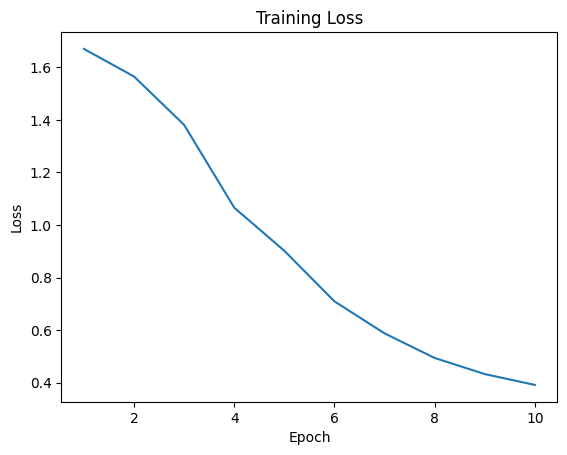

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

# Load datasets
election_2016_data = pd.read_csv('750_random_Sample_2016_election_data_with_predictions.csv', lineterminator='\n')
election_2020_data = pd.read_csv('750_random_Sample_2020_election_data_with_predictions.csv', lineterminator='\n')
election_2020_data = election_2020_data.drop('predicted_sentiment', axis=1)

#Test samples
election_2016_data = election_2016_data.sample(n=750, random_state=44)
election_2020_data = election_2020_data.sample(n=750, random_state=44)

election_2016_data = election_2016_data.reset_index()
election_2020_data = election_2020_data.reset_index()

#Fill na values
# Replace NaN values with an empty string
election_2016_data['Cleaned_Text'].fillna('', inplace=True)
election_2020_data['Cleaned_Text'].fillna('', inplace=True)

# Print the column names of the DataFrame
print(election_2016_data.columns)


# Encode sentiment labels
# Replace 'sentiment' with the correct column name
le = LabelEncoder()
election_2016_data['encoded_sentiment'] = le.fit_transform(election_2016_data['sentiment'])

# Define custom dataset class
class ElectionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #ipdb.set_trace()
        tweet, label = self.df.loc[idx, ['Cleaned_Text', 'encoded_sentiment']]
        enc = self.tokenizer.encode_plus(tweet, add_special_tokens=True, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
        return {key: tensor.flatten() for key, tensor in enc.items()}, torch.tensor(label, dtype=torch.long)

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = ElectionDataset(df, tokenizer, max_len)
    return DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs, labels=labels)
            _, preds = torch.max(outputs.logits, dim=1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    return accuracy_score(y_true, y_pred), classification_report(y_true, y_pred)

# Set up the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(le.classes_))

# Set up training parameters and device
max_len = 128
batch_size = 24
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the data loader
train_data_loader = create_data_loader(election_2016_data, tokenizer, max_len, batch_size)

# Set up the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=epochs * len(train_data_loader)
)

# Initialize the training_losses list
training_losses = []

model.to(device)
# Train the model
for epoch in range(epochs):
    train_loss = train_epoch(model, train_data_loader, optimizer, scheduler, device)
    training_losses.append(train_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}")

# Predict sentiment for the 2020 dataset
election_2020_data['encoded_sentiment'] = -1  # placeholder
test_data_loader = create_data_loader(election_2020_data, tokenizer, max_len, batch_size)
y_2020_pred = []
with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch[0]['input_ids'].to(device)
        attention_mask = batch[0]['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        y_2020_pred.extend(preds.cpu().numpy().tolist())

y_2020_pred = [le.inverse_transform([pred])[0] for pred in y_2020_pred]

election_2020_data['predicted_sentiment'] = y_2020_pred
print(eval_model(model, train_data_loader, device) )
election_2020_data.to_csv('750_random_Sample_2020_election_data_with_predictions_final_output.csv', index=False)

# Print results
print("\nSample of 2020 election data with predicted sentiment:")
print(election_2020_data[['Cleaned_Text', 'predicted_sentiment']].head(10))


# Plot the training loss
plt.plot(range(1, epochs + 1), training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

Analysis/Plots for Roberta Model

   index           created_at      tweet_id  \
0    145  2020-11-01 23:47:02  1.323049e+18   
1    730  2020-11-04 08:21:49  1.323903e+18   
2    692  2020-10-28 16:23:52  1.321488e+18   
3    280  2020-10-28 23:47:35  1.321600e+18   
4    296  2020-10-31 02:33:30  1.322366e+18   
5    640  2020-11-04 20:08:34  1.324081e+18   
6     37  2020-10-24 06:49:40  1.319894e+18   
7    185  2020-11-02 17:46:34  1.323321e+18   
8    391  2020-11-02 13:30:37  1.323256e+18   
9    431  2020-11-05 07:47:38  1.324257e+18   

                                               tweet  likes  retweet_count  \
0  #Facebook #PURGE Is Here, #ProTrump #Groups WI...    0.0            0.0   
1  USA 🇺🇸 election is almost giving me High BP ye...    1.0            0.0   
2  #FB I guess #Trump ran out of money to pay the...    0.0            0.0   
3  A tacit admission that putting #KidsInCages an...    1.0            0.0   
4  @SunshineSt8Sam @realDonaldTrump I’m so excite...    1.0            0.0   
5  #TrumpIsALa

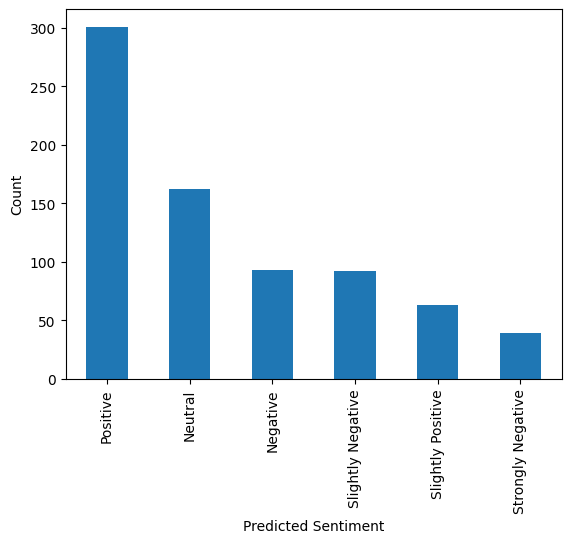

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

# Load datasets
election_2020_data_graph = pd.read_csv('750_random_Sample_2020_election_data_with_predictions_final_use.csv', lineterminator='\n')
print(election_2020_data_graph.head(10))
value_counts = election_2020_data_graph['predicted_sentiment'].value_counts()

# plot the value counts as a bar graph
value_counts.plot(kind='bar')

# set the x-label and y-label
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')

# show the plot
plt.show()

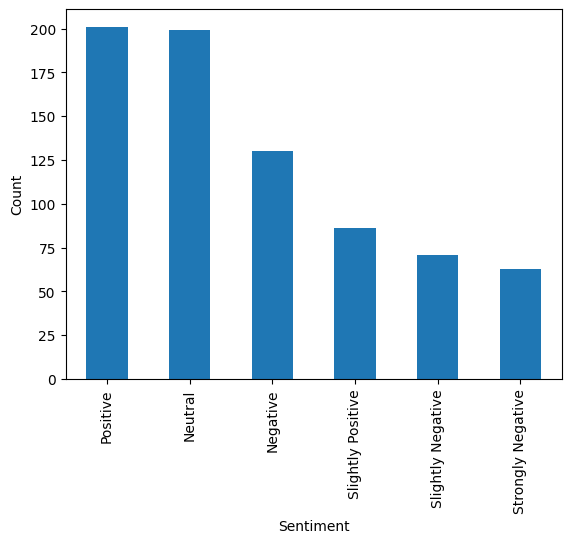

In [ ]:
value_counts = election_2020_data_graph['sentiment'].value_counts()

# plot the value counts as a bar graph
value_counts.plot(kind='bar')

# set the x-label and y-label
plt.xlabel('Sentiment')
plt.ylabel('Count')

# show the plot
plt.show()

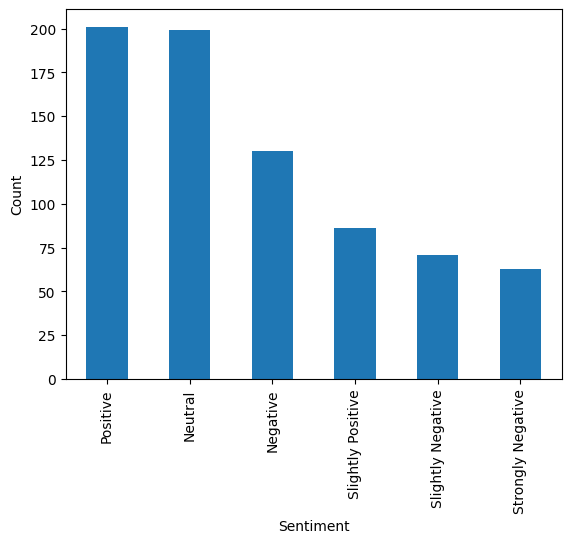

In [ ]:
value_counts = election_2020_data_graph['sentiment'].value_counts()

# plot the value counts as a bar graph
value_counts.plot(kind='bar')

# set the x-label and y-label
plt.xlabel('Sentiment')
plt.ylabel('Count')

# show the plot
plt.show()

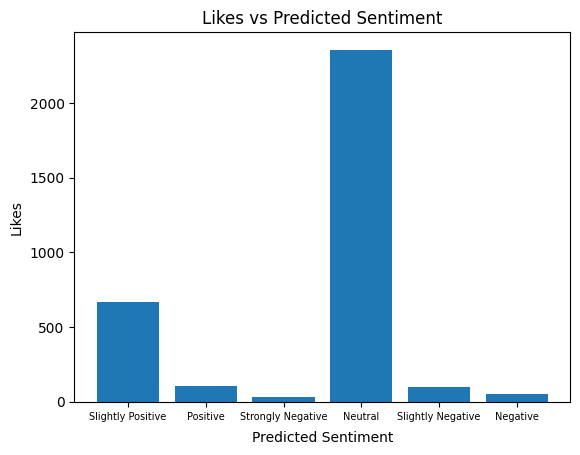

In [ ]:
plt.bar(election_2020_data_graph['predicted_sentiment'], election_2020_data_graph['likes'])
plt.title('Likes vs Predicted Sentiment')
plt.xlabel('Predicted Sentiment', labelpad=7)
plt.ylabel('Likes')
plt.tick_params(axis='x', which='major', labelsize=7)
plt.show()

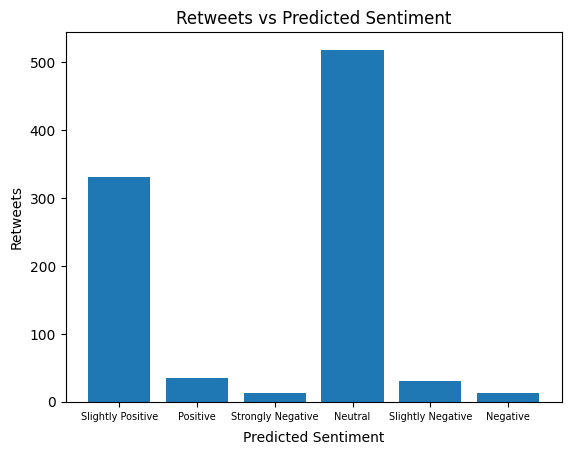

In [ ]:
plt.bar(election_2020_data_graph['predicted_sentiment'], election_2020_data_graph['retweet_count'])
plt.title('Retweets vs Predicted Sentiment')
plt.xlabel('Predicted Sentiment', labelpad=7)
plt.ylabel('Retweets')
plt.tick_params(axis='x', which='major', labelsize=7)
plt.show()